# Projek Klasifikasi gambar bunga
referensi: https://www.kaggle.com/datasets/l3llff/flowers/data

# Import Library

In [1]:
import os, shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tfjs
from glob import glob
from google.colab import files
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, applications, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Persiapan Dataset

In [2]:
!pip install -q kaggle  #install library kaggle

!rm -rf ~/.kaggle  #Hapus konfigurasi lama (jika ada)

from google.colab import files  #upload kaggle.json
print("Upload file kaggle.json Anda")
files.upload()  #upload kaggle.json

# Menambah direktori untuk kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list  #cek dataset yang tersedia

Upload file kaggle.json Anda


Saving kaggle.json to kaggle.json
ref                                                                    title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jayaantanaath/student-habits-vs-academic-performance                   Student Habits vs Academic Performance                   19512  2025-04-12 10:49:08.663000           6504        112  1.0              
kunalgp/top-1000-most-played-spotify-songs-of-all-time                 Top 1000 Most Played Spotify Songs of All Time           53227  2025-04-12 18:13:51.753000           2941         46  0.9411765        
atharvasoundankar/shifting-seas-ocean-climate-and-marine-life-dataset  Shifting Seas: Ocean Climate & Marine Life Dataset        9414  202

In [3]:
!kaggle datasets download -d l3llff/flowers #Unduh dataset

!unzip -q flowers.zip -d flowers_dataset #Ekstraksi dataset

!ls flowers_dataset/flowers/ #Cek struktur

Dataset URL: https://www.kaggle.com/datasets/l3llff/flowers
License(s): CC0-1.0
astilbe		  california_poppy  daffodil   rose
bellflower	  carnation	    dandelion  sunflower
black_eyed_susan  common_daisy	    iris       tulip
calendula	  coreopsis	    magnolia   water_lily


In [4]:
!find flowers_dataset/flowers/ -type f | sed 's/\/[^/]*$//' | sort | uniq -c

    737 flowers_dataset/flowers/astilbe
    873 flowers_dataset/flowers/bellflower
   1000 flowers_dataset/flowers/black_eyed_susan
    978 flowers_dataset/flowers/calendula
   1022 flowers_dataset/flowers/california_poppy
    923 flowers_dataset/flowers/carnation
    980 flowers_dataset/flowers/common_daisy
   1047 flowers_dataset/flowers/coreopsis
    970 flowers_dataset/flowers/daffodil
   1052 flowers_dataset/flowers/dandelion
   1054 flowers_dataset/flowers/iris
   1048 flowers_dataset/flowers/magnolia
    999 flowers_dataset/flowers/rose
   1027 flowers_dataset/flowers/sunflower
   1048 flowers_dataset/flowers/tulip
    982 flowers_dataset/flowers/water_lily


## Split dataset

In [5]:
import os, shutil
from glob import glob
from sklearn.model_selection import train_test_split

BASE_DIR    = 'flowers_dataset'
SOURCE_DIR  = os.path.join(BASE_DIR, 'flowers')
TRAIN_DIR   = os.path.join(BASE_DIR, 'train')
VAL_DIR     = os.path.join(BASE_DIR, 'val')
TEST_DIR    = os.path.join(BASE_DIR, 'test')

# Membuat folder train/val/test
for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    for cls in os.listdir(SOURCE_DIR):
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

# Split dataset; training (70%), validation (15%), test (15%)
for cls in os.listdir(SOURCE_DIR):
    files = glob(f'{SOURCE_DIR}/{cls}/*.jpg')
    train_files, rem = train_test_split(files, train_size=0.7, random_state=42)
    val_files, test_files = train_test_split(rem, train_size=0.5, random_state=42)
    for fpath in train_files:
        shutil.copy(fpath, os.path.join(TRAIN_DIR, cls))
    for fpath in val_files:
        shutil.copy(fpath, os.path.join(VAL_DIR, cls))
    for fpath in test_files:
        shutil.copy(fpath, os.path.join(TEST_DIR, cls))
print("Data selesai displit")

Data selesai displit


# Preprocessing/ Augmentasi Data

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(160,160),
    batch_size=64,
    class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(160,160),
    batch_size=64,
    class_mode='categorical'
)
test_gen = val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(160,160),
    batch_size=64,
    class_mode='categorical'
)

Found 11011 images belonging to 16 classes.
Found 2360 images belonging to 16 classes.
Found 2369 images belonging to 16 classes.


# Pembangunan Model

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks, optimizers

IMG_HEIGHT, IMG_WIDTH = 160, 160
num_classes = 16

# Backbone MobileNetV2
base_model = applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    # Normalisasi
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Backbone
    base_model,

    # konvolusi pasca-backbone
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Global pooling + head
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


# Compile
model.compile(
    optimizer= optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Training & Evaluasi Model

In [8]:
cb = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=cb
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.4640 - loss: 1.7681

173/173 ━━━━━━━━━━━━━━━━━━━━ 107s 548ms/step - accuracy: 0.4648 - loss: 1.7653 - val_accuracy: 0.8254 - val_loss: 0.5560
Epoch 2/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7685 - loss: 0.7517

173/173 ━━━━━━━━━━━━━━━━━━━━ 80s 461ms/step - accuracy: 0.7685 - loss: 0.7516 - val_accuracy: 0.8432 - val_loss: 0.5231
Epoch 3/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 76s 437ms/step - accuracy: 0.8208 - loss: 0.5879 - val_accuracy: 0.8453 - val_loss: 0.5323
Epoch 4/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8315 - loss: 0.5576

173/173 ━━━━━━━━━━━━━━━━━━━━ 75s 435ms/step - accuracy: 0.8315 - loss: 0.5576 - val_accuracy: 0.8504 - val_loss: 0.5010
Epoch 5/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8549 - loss: 0.4925

173/173 ━━━━━━━━━━━━━━━━━━━━ 77s 442ms/step - accuracy: 0.8549 - loss: 0.4925 - val_accuracy: 0.8712 - val_loss: 0.4254
Epoch 6/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8542 - loss: 0.4710

173/173 ━━━━━━━━━━━━━━━━━━━━ 76s 439ms/step - accuracy: 0.8542 - loss: 0.4710 - val_accuracy: 0.8780 - val_loss: 0.4173
Epoch 7/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8681 - loss: 0.4302

173/173 ━━━━━━━━━━━━━━━━━━━━ 77s 443ms/step - accuracy: 0.8681 - loss: 0.4303 - val_accuracy: 0.8784 - val_loss: 0.3956
Epoch 8/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 77s 443ms/step - accuracy: 0.8777 - loss: 0.4078 - val_accuracy: 0.8733 - val_loss: 0.4302
Epoch 9/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 84s 453ms/step - accuracy: 0.8822 - loss: 0.3802 - val_accuracy: 0.8712 - val_loss: 0.4474
Epoch 10/15
173/173 ━━━━━━━━━━━━━━━━━━━━ 76s 437ms/step - accuracy: 0.8858 - loss: 0.3632 - val_accuracy: 0.8737 - val_loss: 0.4172


In [9]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.8863 - loss: 0.4045
Test accuracy: 0.8797, Test loss: 0.4118


## Plot Akurasi & Loss Model

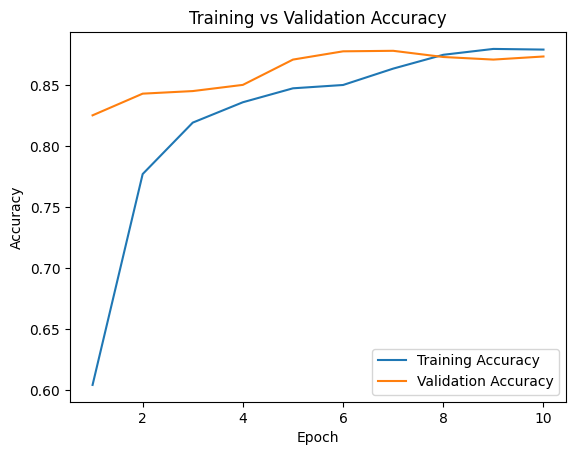

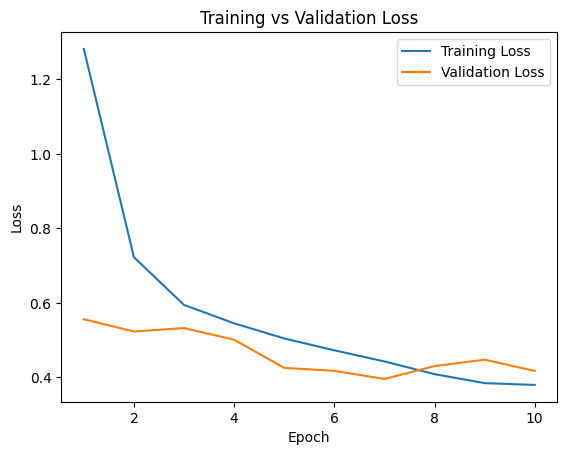

In [10]:
import matplotlib.pyplot as plt

# Misalkan 'history' adalah output dari model.fit(...)
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure()
plt.plot(epochs, acc,      label='Training Accuracy')
plt.plot(epochs, val_acc,  label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure()
plt.plot(epochs, loss,      label='Training Loss')
plt.plot(epochs, val_loss,  label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Simpan Model

In [11]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [12]:
import os
import tensorflow as tf
import tensorflowjs as tfjs

# folder output
os.makedirs('saved_model', exist_ok=True)
os.makedirs('tflite',      exist_ok=True)
os.makedirs('tfjs_model',  exist_ok=True)

# Save SavedModel
model.save("model.keras")
model.export("saved_model")
print("SavedModel disimpan di 'saved_model/'")

# Convert & save ke TFLite
converter   = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)
print("TFLite model disimpan di 'tflite/model.tflite'")

# Simpan label.txt (satu baris per kelas, sesuai indeks output model)
class_indices = train_gen.class_indices
inv_map       = {v:k for k,v in class_indices.items()}
with open('tflite/label.txt', 'w') as f:
    for idx in range(len(inv_map)):
        f.write(f"{inv_map[idx]}\n")
print("label.txt disimpan di 'tflite/label.txt'")

# Convert & save ke TFJS
tfjs.converters.convert_tf_saved_model('saved_model', 'tfjs_model')
print("TFJS model disimpan di 'tfjs_model/' (terdiri dari model.json + *.bin)")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)
Captures:
  139258156702160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139258156702352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139258156708496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139258156709072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139258156708112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139261032065424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139258156707344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139258156701584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139258156709264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139258156707728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13925815670964

In [14]:
from google.colab import files
import shutil

# Zip each model format folder
shutil.make_archive('saved_model', 'zip', 'saved_model')
shutil.make_archive('tflite', 'zip', 'tflite')
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')

# Download the zip files to your local computer
files.download('saved_model.zip')
files.download('tflite.zip')
files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Inferensi

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step


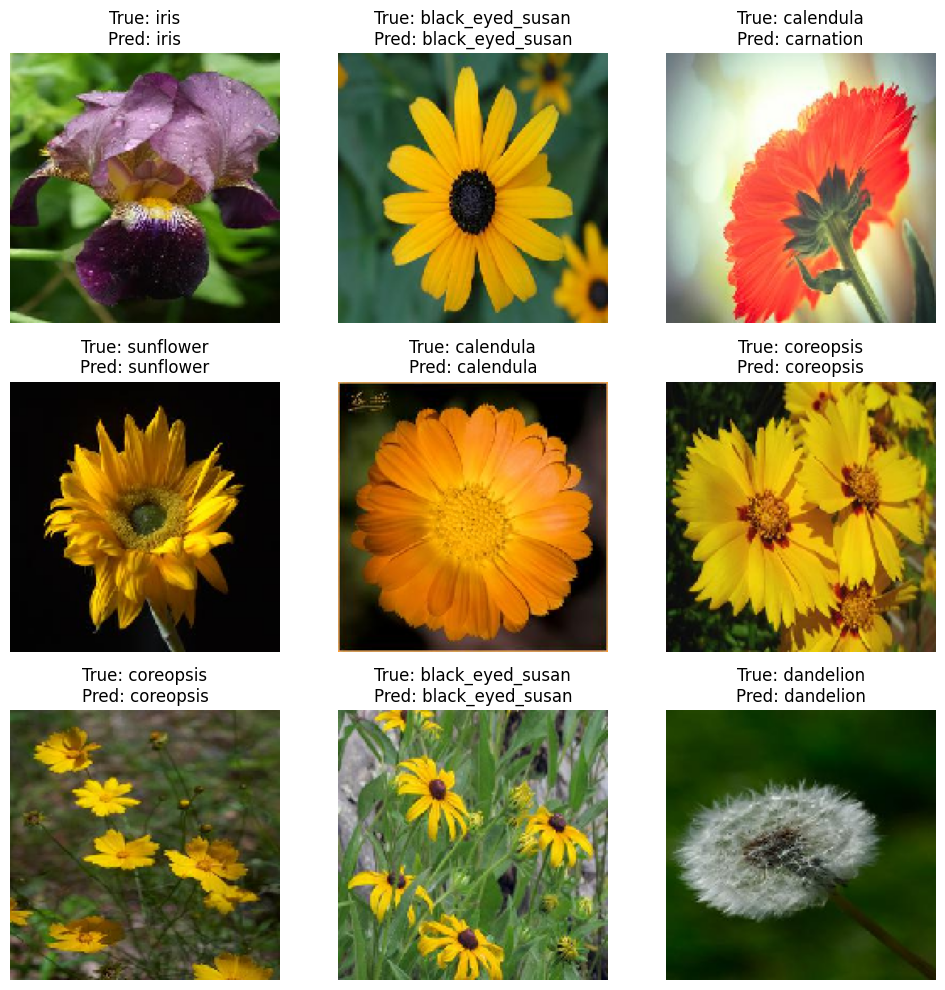

In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load model
model = load_model('best_model.h5')

images, labels = next(test_gen)  # test_gen berasal dari ImageDataGenerator

# Melakukan prediksi
preds = model.predict(images)
pred_indices = preds.argmax(axis=1)
true_indices = labels.argmax(axis=1)

# Mapping index ke nama kelas
class_indices = train_gen.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

# Tampilkan 9 sampel dengan prediksi vs ground-truth
plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    true_label = inv_class_indices[true_indices[i]]
    pred_label = inv_class_indices[pred_indices[i]]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()